In [1]:
import os, sys
import dotenv

import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.environ.get('PATH_OPENSKY'))
from user_eval import get_df_posts 
from news_outlet_eval import get_news_feed, get_posts_from_nos

dotenv.load_dotenv('.env')    
PATH_DATA = os.environ.get('PATH_OPENSKY') + os.environ.get('PATH_REL_DATA')
PATH_USER_POSTS = PATH_DATA + 'user_posts/'

PATH_RESULTS = os.environ.get('PATH_OPENSKY') + 'results/'
PATH_USER_REPLIES_NEWS_POSTS = PATH_RESULTS + 'agg_user_replies_news_posts_2.csv'
PATH_ALL_SENTIMENTS = os.environ.get('PATH_OPENSKY') + 'results/all_sentiments_over_time.csv'


In [2]:
df_news_posts = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)
bm_first_depth = (df_news_posts.reply_to == df_news_posts.thread_root)
df_news_posts = df_news_posts[bm_first_depth]
df_news_posts.dropna(subset=['sent_label'], inplace=True)
df_news_posts['date'] = pd.to_datetime(df_news_posts['date'], errors='coerce')

sent_label_mapping = { 0: 'negative', 1: 'neutral', 2: 'positive'}
df_news_posts.loc[:, 'sent_label'] = df_news_posts.sent_label.map(sent_label_mapping)
df_news_posts

/tmp/ipykernel_1888105/4123129271.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_news_posts = pd.read_csv(PATH_USER_REPLIES_NEWS_POSTS)
/tmp/ipykernel_1888105/4123129271.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['positive' 'positive' 'neutral' ... 'negative' 'negative' 'neutral']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_news_posts.loc[:, 'sent_label'] = df_news_posts.sent_label.map(sent_label_mapping)


,post_id,user_id,instance,date,text,langs,like_count,reply_count,repost_count,reply_to,replied_author,thread_root,thread_root_author,repost_from,reposted_author,quotes,quoted_author,labels,sent_label,sent_score
0,10657080,284413,bsky.social,2024-01-14 08:03:00,let’s hope his expands ten fold 💪💪,['eng'],0,0,0,10657081.0,15717.0,10657081.0,15717.0,NaN,NaN,NaN,NaN,NaN,positive,0.945
1,10657084,284413,bsky.social,2024-01-12 22:12:00,"yes, we can do this! 💪",['eng'],3,0,0,5595208.0,2486.0,5595208.0,2486.0,NaN,NaN,NaN,NaN,NaN,positive,0.956
2,10657085,284413,bsky.social,2024-01-11 14:19:00,"in other words, “as long as it takes” it refer...",['eng'],0,1,0,10657086.0,12030.0,10657086.0,12030.0,NaN,NaN,NaN,NaN,NaN,neutral,0.583
3,10657096,284413,bsky.social,2024-01-08 14:10:00,i’ll believe it when i see the weapons in Ukra...,['eng'],0,0,0,10657097.0,15717.0,10657097.0,15717.0,NaN,NaN,NaN,NaN,NaN,neutral,0.509
4,10657117,284413,bsky.social,2024-01-05 09:22:00,Expect the world to become way way worse. If a...,['eng'],1,0,0,5271912.0,15717.0,5271912.0,15717.0,NaN,NaN,NaN,NaN,NaN,negative,0.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36812,110584107,527683,bsky.social,2023-10-06 20:06:00,Are you kidding?\n\nThere are always people wh...,['eng'],3,1,0,4108566.0,379.0,4108566.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.929
36817,105014318,92560,bsky.social,2024-03-08 01:59:00,What a complete abdication of good journalism ...,['eng'],0,0,0,698597.0,9.0,698597.0,9.0,NaN,NaN,NaN,NaN,NaN,negative,0.790
36818,105014322,92560,bsky.social,2024-03-07 22:16:00,Trump and Biden are at par with age...exactly ...,['eng'],4,0,0,127576.0,379.0,127576.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.867
36819,105014501,92560,bsky.social,2024-01-05 08:08:00,Because doctors are literally refusing to pres...,['eng'],1,0,0,145919.0,379.0,145919.0,379.0,NaN,NaN,NaN,NaN,NaN,negative,0.882


In [3]:
df_news_posts.thread_root_author.nunique()

65

In [4]:
df_all_replies = pd.read_csv(PATH_ALL_SENTIMENTS, index_col=0)
df_all_replies.loc[:, 'sent_label'] = df_all_replies.sent_label.map(sent_label_mapping)
df_all_replies['date'] = pd.to_datetime(df_all_replies['date'], errors='coerce')

# Removing all posts present in the news feed replies df
bm_not_in_news_feed = ~df_all_replies.post_id.isin(df_news_posts.post_id)
df_all_replies = df_all_replies[bm_not_in_news_feed]

df_all_replies

/tmp/ipykernel_1888105/1780271783.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['negative' 'neutral' 'negative' ... 'positive' 'positive' 'neutral']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_all_replies.loc[:, 'sent_label'] = df_all_replies.sent_label.map(sent_label_mapping)


,post_id,user_id,date,labels,sent_label,sent_score,reply_to,thread_root
9,79798842,527934,2024-03-18 01:33:00,NaN,negative,0.939,79798843.0,79798843.0
34,79798860,527934,2024-03-16 21:16:00,NaN,neutral,0.757,51667361.0,51667361.0
40,79798869,527934,2024-03-16 04:31:00,NaN,negative,0.791,79798870.0,79798870.0
42,79798871,527934,2024-03-16 02:37:00,NaN,positive,0.985,79798872.0,79798872.0
80,79798908,527934,2024-03-13 20:05:00,NaN,negative,0.930,79798838.0,79798838.0
...,...,...,...,...,...,...,...,...
21,1314169,3401925,2024-02-23 15:38:00,NaN,neutral,0.630,1314170.0,1314170.0
33,1314182,3401925,2024-02-13 04:12:00,NaN,neutral,0.634,1314183.0,1314183.0
40,1314189,3401925,2024-02-08 22:14:00,NaN,positive,0.978,1314190.0,1314190.0
44,1314193,3401925,2024-02-07 08:33:00,NaN,positive,0.844,1314194.0,1314194.0


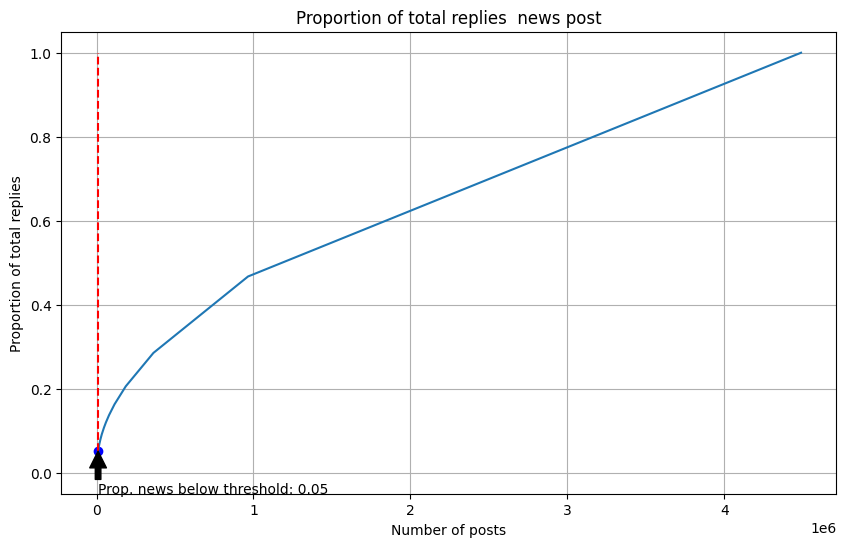

In [9]:
reply_counts = df_all_replies.groupby('reply_to').size().sort_values(ascending=False).reset_index(name='count')

# Calculate the cumulative sum
cumulative_replies = reply_counts['count'].cumsum()
cumulative_replies = cumulative_replies / cumulative_replies.max()
origin = pd.Series([0])
cumulative_replies = pd.concat([origin, cumulative_replies]).reset_index(drop=True)
cumulative_replies.reset_index(drop=True)[1e6]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cumulative_replies)
ax.set_xlabel('Number of posts')
ax.set_ylabel('Proportion of total replies')
ax.set_title('Proportion of total replies  news post')

news_reply_threshold = 10000
ax.vlines(news_reply_threshold, 0, 1, color='red', linestyle='--')

intersection_y = cumulative_replies.iloc[news_reply_threshold] if news_reply_threshold < len(cumulative_replies) else 1
ax.scatter(news_reply_threshold, intersection_y, color='blue')
ax.annotate(f'Prop. news below threshold: {intersection_y:.2f}', 
            xy=(news_reply_threshold, intersection_y), 
            xytext=(news_reply_threshold + 50, intersection_y - 0.1),
            arrowprops=dict(facecolor='black', shrink=1))

ax.grid(True)

In [13]:
reply_counts[reply_counts['count'] >= 4]

np.int64(719616)

In [5]:
df_news_posts_agg = df_news_posts.groupby('sent_label').agg({'sent_label': 'count'})
df_all_replies_agg = df_all_replies.groupby('sent_label').agg({'sent_label': 'count'})
cont_table = df_news_posts_agg.join(df_all_replies_agg, lsuffix='_news_replies', rsuffix='_not_news_replies').T
#cont_table['total'] = cont_table.sum(axis=1)
#cont_table  = cont_table.T
#cont_table['total'] = cont_table.sum(axis=1)
cont_table

sent_label,negative,neutral,positive
sent_label_news_replies,9664,5046,1908
sent_label_not_news_replies,1667351,2483904,2461271


In [6]:
from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(cont_table)
print(f'Chi2: {chi2}, p: {p}, dof: {dof}')

Chi2: 10293.764569128034, p: 0.0, dof: 2


In [7]:
np.set_printoptions(precision=15)
print(p)

0.0


In [8]:
    ex

array([[   4203.956841184925,    6239.323070972662,    6174.720087842412],
       [1672811.043158815   , 2482710.6769290273  , 2457004.2799121574  ]])

In [9]:
df_news_posts.groupby('reply_to').agg({'sent_label': 'count'}).sort_values('sent_label', ascending=False).head(13).index.tolist()

[83904.0,
 126715.0,
 26242.0,
 134087.0,
 158825.0,
 109343.0,
 600586.0,
 122425.0,
 183511.0,
 378714.0,
 118661.0,
 202460.0,
 479706.0]

In [10]:
cont_table

sent_label,negative,neutral,positive
sent_label_news_replies,9664,5046,1908
sent_label_not_news_replies,1667351,2483904,2461271


In [11]:
cont_table.index

Index(['sent_label_news_replies', 'sent_label_not_news_replies'], dtype='object')

In [12]:
cont_table.loc['sent_label_news_replies'].values.flatten()

array([9664, 5046, 1908])

In [13]:
news_proportions = cont_table.loc['sent_label_news_replies'].values.flatten()
non_news_proportions = cont_table.loc['sent_label_not_news_replies'].values.flatten()

# Normalize the data
news_proportions = news_proportions / news_proportions.sum()
non_news_proportions = non_news_proportions / non_news_proportions.sum()

news_proportions, non_news_proportions

(array([0.581538091226381, 0.303646648212781, 0.114815260560838]),
 array([0.252150388520211, 0.375636178973058, 0.37221343250673 ]))

In [14]:
COLOR_POSITIVE = os.environ.get('COLOR_POSITIVE')
COLOR_NEUTRAL = os.environ.get('COLOR_NEUTRAL')
COLOR_NEGATIVE = os.environ.get('COLOR_NEGATIVE')

In [15]:
COLOR_NEGATIVE

'#ff7f0e'

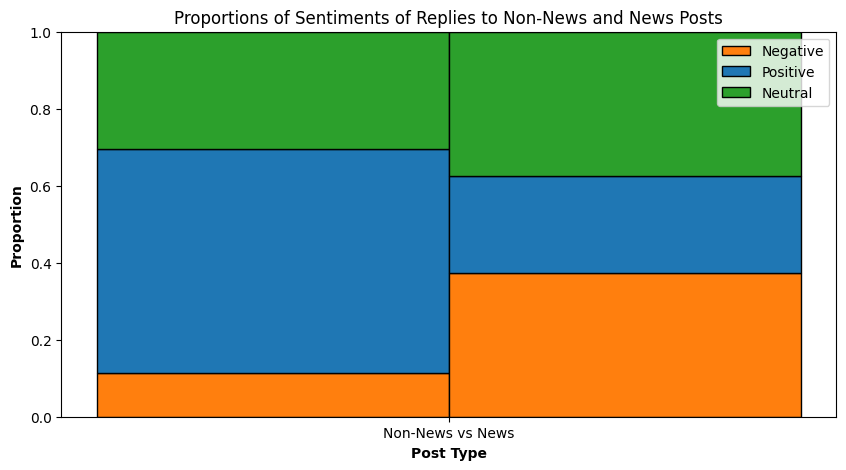

In [17]:
# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r = np.arange(1)

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars for news proportions
ax.bar(r, news_proportions[2], color=COLOR_NEGATIVE, width=bar_width, edgecolor='black', label='Negative')
ax.bar(r, news_proportions[0], bottom=news_proportions[2], color=COLOR_POSITIVE, width=bar_width, edgecolor='black', label='Positive')
ax.bar(r, news_proportions[1], bottom=news_proportions[2] + news_proportions[0], color=COLOR_NEUTRAL, width=bar_width, edgecolor='black', label='Neutral')

# Plot bars for non-news proportions without labels
ax.bar(r + bar_width, non_news_proportions[2], color=COLOR_NEGATIVE, width=bar_width, edgecolor='black')
ax.bar(r + bar_width, non_news_proportions[0], bottom=non_news_proportions[2], color=COLOR_POSITIVE, width=bar_width, edgecolor='black')
ax.bar(r + bar_width, non_news_proportions[1], bottom=non_news_proportions[2] + non_news_proportions[0], color=COLOR_NEUTRAL, width=bar_width, edgecolor='black')

# Add labels
ax.set_xlabel('Post Type', fontweight='bold')
ax.set_ylabel('Proportion', fontweight='bold')
ax.set_title('Proportions of Sentiments of Replies to Non-News and News Posts')
ax.set_xticks([r + bar_width / 2 for r in range(1)])
ax.set_xticklabels(['Non-News vs News'])
ax.set_ylim(0, 1)

# Add legend
ax.legend()